First image: /content/drive/MyDrive/football-player-segmentation/images/0.jpg


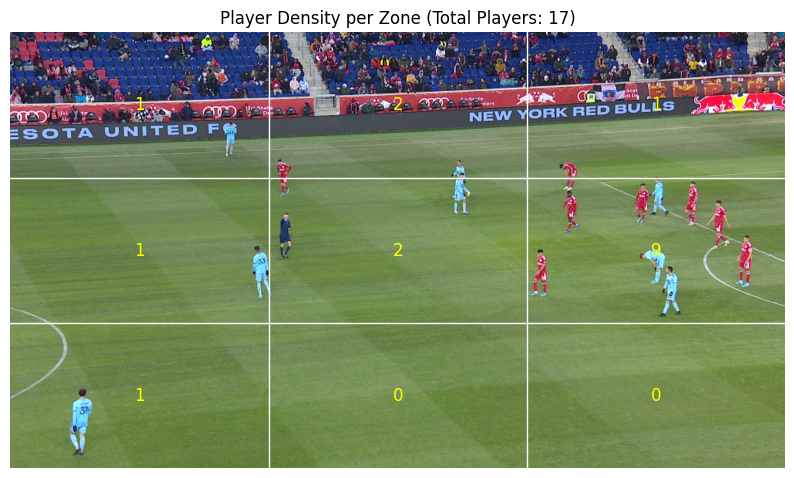

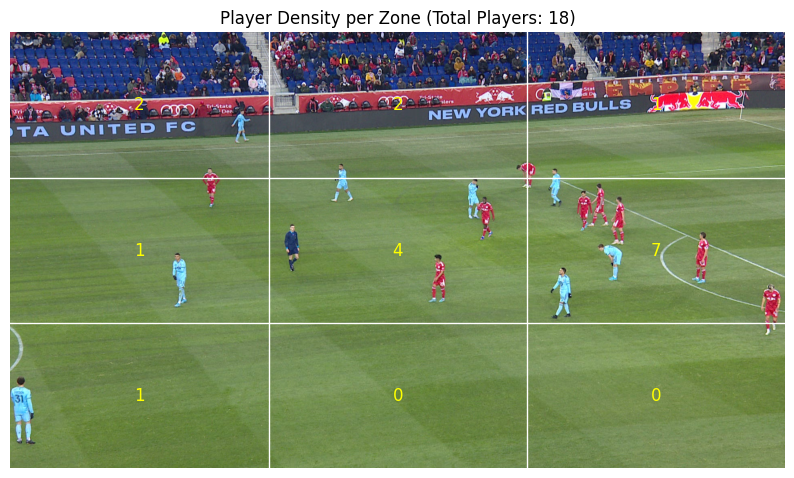

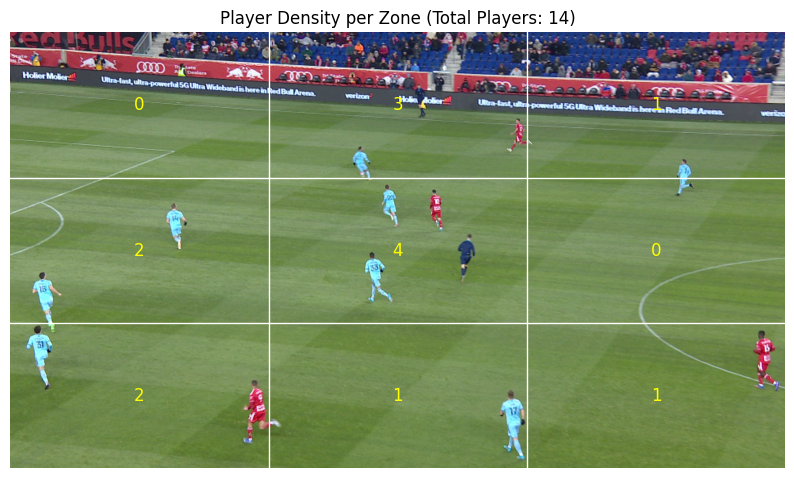


--- Average Player Density per Zone ---
Zone_0: 0.94
Zone_1: 2.76
Zone_2: 1.40
Zone_3: 2.56
Zone_4: 3.02
Zone_5: 2.86
Zone_6: 0.43
Zone_7: 0.44
Zone_8: 0.61


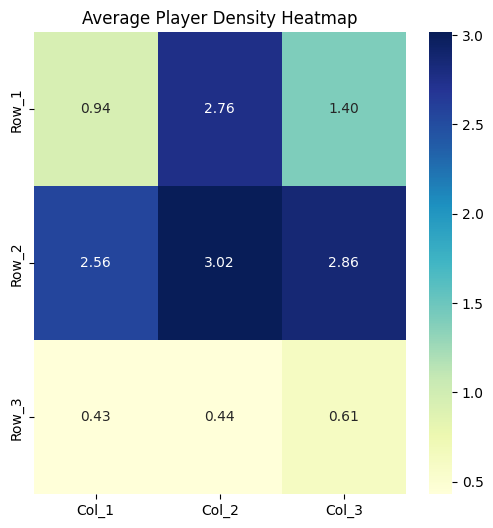

In [43]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from glob import glob
import seaborn as sns  # For heatmap visualization

# --- 1. Data Loading and Setup ---
# Define paths to the images and annotations directories
images_path = '/content/drive/MyDrive/football-player-segmentation/images'
annotations_path = '/content/drive/MyDrive/football-player-segmentation/annotations'

# Load image files
image_files = sorted(glob(os.path.join(images_path, '*.jpg')))
if not image_files:
    raise FileNotFoundError(f"No .jpg files found in {images_path}")

# Load the first image path for potential use
sample_image = image_files[0]
print(f"First image: {sample_image}")

# Load the main annotation file containing instance information
annotations_file = os.path.join(annotations_path, 'instances_default.json')
with open(annotations_file) as f:
    annotations_data = json.load(f)

# --- 2. Helper Functions ---
# Function to extract annotation shapes for a specific image
def get_shapes_for_image(image_filename, annotations):
    """
    Retrieves the annotation shapes (polygons) for a given image filename
    from the loaded COCO-style annotations.
    """
    for item in annotations['images']:
        if item['file_name'] == os.path.basename(image_filename):
            image_id = item['id']
            shapes = []
            for ann in annotations['annotations']:
                if ann['image_id'] == image_id:
                    shapes.append(ann)
            return shapes
    return []

# Function to create a binary mask from annotation shapes
def create_mask_from_shapes(shapes, image_shape):
    """
    Generates a binary mask (NumPy array) from a list of annotation shapes.
    Pixels within the shapes are set to 255, and the background to 0.
    """
    mask = Image.new('L', (image_shape[1], image_shape[0]), 0)
    draw = ImageDraw.Draw(mask)
    for shape in shapes:
        if 'segmentation' in shape:
            for polygon in shape['segmentation']:
                points = [(polygon[i], polygon[i+1]) for i in range(0, len(polygon), 2)]
                draw.polygon(points, fill=255)
    return np.array(mask)

# Function to define zones within the image grid
def define_image_zones(image_height, image_width, num_rows=3, num_cols=3):
    """
    Divides the image into a grid of equal-sized rectangular zones.
    Returns a dictionary where keys are zone names and values are (startX, endX, startY, endY) tuples.
    """
    zones = {}
    row_height = image_height // num_rows
    col_width = image_width // num_cols
    zone_index = 0
    for r in range(num_rows):
        for c in range(num_cols):
            start_y = r * row_height
            end_y = (r + 1) * row_height
            start_x = c * col_width
            end_x = (c + 1) * col_width
            zones[f"Zone_{zone_index}"] = (start_x, end_x, start_y, end_y)
            zone_index += 1
    return zones

# Function to analyze player count per image zone
def analyze_players_per_zone(image_path, annotations, num_rows=3, num_cols=3):
    """
    Counts the number of distinct players whose mask pixels significantly overlap
    with each defined zone in the image.
    """
    image = cv2.imread(image_path)
    height, width = image.shape[:2]
    zones = define_image_zones(height, width, num_rows, num_cols)
    shapes = get_shapes_for_image(image_path, annotations)
    player_counts_per_zone = {zone_name: 0 for zone_name in zones}

    for shape in shapes:
        individual_player_mask = create_mask_from_shapes([shape], (height, width))
        player_pixels_y, player_pixels_x = np.where(individual_player_mask > 0)
        total_player_pixels = player_pixels_y.size

        for zone_name, (start_x, end_x, start_y, end_y) in zones.items():
            overlap_pixels = np.sum(
                (player_pixels_x >= start_x) & (player_pixels_x < end_x) &
                (player_pixels_y >= start_y) & (player_pixels_y < end_y)
            )
            if total_player_pixels > 0 and (overlap_pixels / total_player_pixels) > 0.1: # Player significantly in the zone
                player_counts_per_zone[zone_name] += 1
                break # Count each player in at most one zone

    total_players = len(shapes)
    return player_counts_per_zone, total_players

# Function to visualize the image with zone grid and player counts
def show_image_with_zone_density(image_path, annotations, num_rows=3, num_cols=3):
    """
    Displays the original image with an overlaid grid representing the zones.
    The number of players detected in each zone is displayed within the zone.
    """
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    height, width = image.shape[:2]
    zones = define_image_zones(height, width, num_rows, num_cols)
    player_counts_per_zone, total_players = analyze_players_per_zone(image_path, annotations, num_rows, num_cols)

    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.title(f'Player Density per Zone (Total Players: {total_players})')

    row_height = height // num_rows
    col_width = width // num_cols

    # Draw grid lines
    for i in range(1, num_rows):
        plt.axhline(i * row_height, color='white', linestyle='-', linewidth=1)
    for j in range(1, num_cols):
        plt.axvline(j * col_width, color='white', linestyle='-', linewidth=1)

    # Display player counts in each zone
    zone_index = 0
    for r in range(num_rows):
        for c in range(num_cols):
            zone_name = f"Zone_{zone_index}"
            count = player_counts_per_zone.get(zone_name, 0)
            text_x = int(c * col_width + col_width / 2)
            text_y = int(r * row_height + row_height / 2)
            plt.text(text_x, text_y, str(count), color='yellow', fontsize=12, ha='center', va='center')
            zone_index += 1

    plt.axis('off')
    plt.show()

# --- 3. Main Analysis and Visualization ---
# Visualize player density for a few sample images
num_visualizations = 3
for i, image_file in enumerate(image_files[:num_visualizations]):
    show_image_with_zone_density(image_file, annotations_data, num_rows=3, num_cols=3)

# --- 4. Aggregate Analysis ---
# Function to calculate the average player density per zone across multiple images
def aggregate_player_density_per_zone(image_files, annotations, num_rows=3, num_cols=3):
    """
    Calculates the average number of players per zone across a set of images.
    """
    all_zone_counts = {f"Zone_{i}": 0 for i in range(num_rows * num_cols)}
    total_analyzed_players = 0
    num_aggregate_samples = len(image_files) # Analyze all images

    for image_file in image_files[:num_aggregate_samples]:
        zone_counts, total_players = analyze_players_per_zone(image_file, annotations, num_rows, num_cols)
        for zone, count in zone_counts.items():
            all_zone_counts[zone] += count
        total_analyzed_players += total_players

    average_zone_density = {
        zone: count / num_aggregate_samples if num_aggregate_samples > 0 else 0
        for zone, count in all_zone_counts.items()
    }
    return average_zone_density

# Calculate and print the average player density per zone
average_density = aggregate_player_density_per_zone(image_files, annotations_data, num_rows=3, num_cols=3)
print("\n--- Average Player Density per Zone ---")
for zone, density in average_density.items():
    print(f"{zone}: {density:.2f}")

# --- 5. Heatmap Visualization of Average Density ---
# Visualize the average player density as a heatmap
density_matrix = np.array(list(average_density.values())).reshape(3, 3)
plt.figure(figsize=(6, 6))
sns.heatmap(density_matrix, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=[f"Col_{i+1}" for i in range(3)],
            yticklabels=[f"Row_{i+1}" for i in range(3)])
plt.title("Average Player Density Heatmap")
plt.show()